In [ ]:
import os
import librosa
import numpy as np
import librosa
import shutil
import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, losses, models, optimizers, metrics, callbacks
import matplotlib.pyplot as plt
from IPython.display import FileLink

# Create Melspectograms

In [2]:
DATASET_DIR = ""
CLASSES = ['Ney', 'Santur', 'Ud', 'Tar', 'Setar', 'Kamancheh']


if os.path.exists("./mel_dataset"):
    shutil.rmtree("./mel_dataset")

for c in CLASSES:
    os.makedirs(f"./mel_dataset/{c}")
CLASSES_DICT = {g:i for i,g in enumerate(CLASSES)}
DEFAULT_SHAPE = (128, 120)


def fix_shape(spectogram, default_shape=DEFAULT_SHAPE):
    if spectogram.shape[1] < default_shape[1]:
        diff = default_shape[1] - spectogram.shape[1]
        return np.append(spectogram, np.zeros((spectogram.shape[0], diff)), axis=1)
    if spectogram.shape[1] > default_shape[1]:
        return spectogram[:, :default_shape[1]]
    return spectogram

def process_song(song_path, overwrite=False):
    basename, ext = os.path.splitext(song_path)
    instrument, filename = basename.split("/")[-2:]
    y, sr = librosa.load(song_path, mono=True)

    spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=1024)
    spectogram = librosa.power_to_db(spectogram, ref=np.max)
    spectogram = fix_shape(spectogram)
    spectogram = (spectogram - np.min(spectogram))/(np.max(spectogram) - np.min(spectogram))
    spectogram = np.float32(np.transpose(spectogram))
    np.save(f"./mel_dataset/{instrument}/{filename}.npy",spectogram)

        
filenames = glob.glob("/kaggle/input/pcmir-database/Persian Classical Music Instrument Recognition (PCMIR) Database/**/**.mp3")

for filename in tqdm(filenames):
    process_song(filename, overwrite=False)


100%|██████████| 2410/2410 [01:36<00:00, 24.92it/s]


# Helper function for displaying a melspectogram

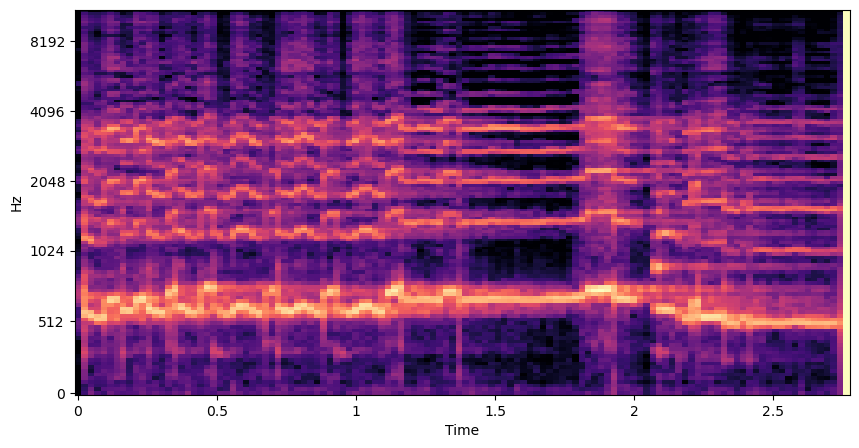

In [31]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
def plot_spectogram(x, tag=None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(x.T, y_axis='mel', x_axis='time')
    if tag:
        plt.title('Melspectogram for ' + g + '[0]')
        plt.tight_layout()

spect = np.load("./mel_dataset/Ney/Ney (10).npy")
plot_spectogram(spect)

# A Generator for loading melspectograms

In [4]:
class generator(tf.keras.utils.Sequence):
    def __init__(self, filenames, batch_size, shuffle, classes, **kwargs):
        super().__init__(**kwargs)
        self.filenames = filenames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.classes = classes
        self.class_ids = {}
        for i,c in enumerate(classes):
            self.class_ids[c] = i
            
    def __getitem__(self, index):
        f = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        mels = np.array([np.load(m) for m in f], dtype=np.float32)
        
        labels = [self.class_ids[m.split("/")[-2]] for m in f]
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes), dtype=np.float32)
        return mels, labels

    def __len__(self):
        return np.ceil(len(self.filenames)/self.batch_size).astype("int32")

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)


# Train, Validation, and Test Splits with ratio of 0.75 : 0.05 : 0.20

In [5]:
mel_filenames = glob.glob("./mel_dataset/**/*.npy")
np.random.shuffle(mel_filenames)
N = len(mel_filenames)

tr_ratio, vl_ratio, te_ratio = .75, .05, .20

trf = mel_filenames[:int(tr_ratio*N)]
vlf = mel_filenames[int(tr_ratio*N):int((tr_ratio+vl_ratio)*N)]
tef = mel_filenames[-int(te_ratio*N):]
print(f"train_len={len(trf)},val_len={len(vlf)},te_len={len(tef)}")

trgen = generator(filenames=trf, batch_size=32, shuffle=True, classes=CLASSES)
vlgen = generator(filenames=vlf, batch_size=32, shuffle=False,classes=CLASSES)
tegen = generator(filenames=tef, batch_size=1, shuffle=False,classes=CLASSES)


train_len=1807,val_len=121,te_len=482


# Main model

In [10]:
def get_model(input_shape, num_classes, batchnorm=True, activation='softmax'):
    input_layer = layers.Input(shape=input_shape)
    layer = input_layer
    for i in range(3):
        layer = layers.Conv1D(filters=256, kernel_size=4,
                       strides=2, padding='same',
                       kernel_initializer='glorot_normal',use_bias=False)(layer)
        layer = layers.LayerNormalization()(layer)
        layer = layers.Activation('relu')(layer)

    layer = layers.LSTM(units=256,return_sequences=False)(layer)
    layer = layers.Dense(units=num_classes)(layer)
    layer = layers.Activation(activation)(layer)
    return models.Model(inputs=input_layer, outputs=layer)


# Define Training args and components

In [12]:
model = None
model = get_model((None,128), len(CLASSES))

print(model.summary(line_length=128))
optimizer = optimizers.AdamW(lr=1e-4,weight_decay=1e-4)
rec, pre = metrics.Recall(name='rec'),metrics.Precision(name='pre')
save_best = callbacks.ModelCheckpoint("./best.h5",monitor="val_rec",mode="max",save_best_only=True, verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',pre, rec])

Model: "model_2"
________________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                       Param #             
 input_3 (InputLayer)                                    [(None, None, 128)]                                0                   
                                                                                                                                
 conv1d_6 (Conv1D)                                       (None, None, 256)                                  131072              
                                                                                                                                
 layer_normalization_6 (LayerNormalization)              (None, None, 256)                                  512                 
                                                                                

# Train

In [13]:
hist = model.fit(x=trgen, validation_data=vlgen, callbacks=[save_best],epochs=150)

Epoch 1/150
56/57 [============================>.] - ETA: 0s - loss: 1.8444 - accuracy: 0.1775 - pre: 0.1250 - rec: 0.0023
Epoch 1: val_rec improved from -inf to 0.00000, saving model to ./best.h5
57/57 [==============================] - 13s 34ms/step - loss: 1.8438 - accuracy: 0.1754 - pre: 0.1250 - rec: 0.0022 - val_loss: 1.8098 - val_accuracy: 0.1570 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/150
55/57 [===========================>..] - ETA: 0s - loss: 1.8039 - accuracy: 0.1807 - pre: 0.0000e+00 - rec: 0.0000e+00
Epoch 2: val_rec did not improve from 0.00000
57/57 [==============================] - 1s 20ms/step - loss: 1.8025 - accuracy: 0.1826 - pre: 0.0000e+00 - rec: 0.0000e+00 - val_loss: 1.7503 - val_accuracy: 0.2893 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 3/150
56/57 [============================>.] - ETA: 0s - loss: 1.5592 - accuracy: 0.3330 - pre: 0.5972 - rec: 0.0485
Epoch 3: val_rec improved from 0.00000 to 0.15702, saving model to ./best.h5
57/57 [======

# Evaluate on test set

In [17]:
model = None
model = models.load_model("./best.h5")
model.evaluate(tegen)

482/482 [==============================] - 3s 5ms/step - loss: 0.4454 - accuracy: 0.9025 - pre: 0.9095 - rec: 0.8963


[0.4453863501548767,
 0.9024896025657654,
 0.9094736576080322,
 0.8962655663490295]

# Get Instrument dist over time
## To this end :
### 1) Change the LSTM layer to return the whole sequences instead of the last output
### 2) Equip the last Dense layer with a TimeDistributed layer so that it gets applied on the previous layers output
### 3) Load layer weights from trained model


In [32]:
def get_model_for_dist_over_time(input_shape, num_classes, batchnorm=True, activation='softmax'):
    input_layer = layers.Input(shape=input_shape)
    layer = input_layer
    for i in range(3):
        layer = layers.Conv1D(filters=256, kernel_size=4,
                       strides=2, padding='same',
                       kernel_initializer='glorot_normal',use_bias=False)(layer)
        layer = layers.LayerNormalization()(layer)
        layer = layers.Activation('relu')(layer)

    layer = layers.LSTM(units=256,return_sequences=True)(layer)
    layer = layers.TimeDistributed(layers.Dense(units=num_classes))(layer)
    layer = layers.Activation(activation)(layer)
    return models.Model(inputs=input_layer, outputs=layer)


In [27]:
dist_model = None
dist_model = get_model_for_dist_over_time((None,128), len(CLASSES))
dist_model.load_weights("./best.h5")

for x,y in tegen:
    pred = dist_model(x)
    pred = np.squeeze(np.argmax(pred,-1))
    print(f"True Class for whole song :{CLASSES[np.argmax(y)]}")
    print("Song Instrument Distribution over time:",[CLASSES[i] for i in pred])
    break
# p = model(a[np.newaxis])
# np.argmax(p,axis=2)

True Class for whole song :Tar
Song Instrument Distribution over time: ['Ney', 'Tar', 'Ney', 'Ney', 'Tar', 'Tar', 'Tar', 'Ney', 'Tar', 'Tar', 'Tar', 'Tar', 'Tar', 'Tar', 'Tar']
